# BigMart Sales Forecasting

<img src="./Downloads/R.png" width="100%" height="10%">

![](R.png)

## Outline:
1. Importing important Libraries
2. Loading the data
3. Exploratory Data Analysis(EDA) and Visualization.
4. Feature Engineering
5. Model Building, Evaluation and Hyperparameter Tuning.
6. Feature Selection
7. Design of a Machine Learning Pipeline.

# 1. Importing important Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

# 2. Loaing the data

In [317]:
train_df = pd.read_csv('D:/sqldatasets/train.csv')
test_df = pd.read_csv('D:/sqldatasets/test.csv')

In [318]:
## viewing the first and last 5 columns of train_df
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [319]:
train_df.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976
8522,DRG01,14.800,Low Fat,0.044878,Soft Drinks,75.4670,OUT046,1997,Small,Tier 1,Supermarket Type1,765.6700


## 3. EDA and Visualization(Descriptive Analysis)
The objectives of this section include;

1. Checking the size of the data and the type of information found in the dataset.
2. Indentifying outliers,skewness and NaN values in the dataset.
3. Have a good understanding of the various method used in identifying outliers and skewed data.
4. Identifying the numerical and categorical columns in the dataset.
5. Understanding the relationship between independent and dependent variables.
6. Statistical Summary of the data.

### 1. Size of dataset

In [320]:
# The size of the dataset
print('Train_size:{} Test_size:{}'.format(train_df.shape,test_df.shape))

Train_size:(8523, 12) Test_size:(5681, 11)


The training set has _8523_ records with 12 features

In [321]:
# Type of information found in the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


It could be observed from the information above that there are 7 categorical features and 5 numerical features.

### 2. NaN values Identification

In [322]:
# Defining a function to check for NaN values
def check_NaN(df):
    NaN_info = pd.DataFrame(np.array(df.isnull().sum().sort_values(ascending = False).reset_index()),
               
              columns = ['Columns','NaN_percent']).query('NaN_percent > 0').set_index('Columns')
    return np.round(100*NaN_info/df.shape[0],2)
check_NaN(train_df)

,NaN_percent
Columns,
Outlet_Size,28.276428
Item_Weight,17.165317


It could be observed that the _Outlet_size_ and _Item_Weight_ columns are the columns with NaN values. The Outlet_size columns has about 28% of missing values while for Item_Weight column has about 17% of it values are missing. 

Therefore imputation can still be performed on these columns rather than droping them.

### 3. Identifying Numerical and Categorical Features

### Numerical features

In [323]:
num_features = train_df.select_dtypes(exclude = 'object').columns.tolist()

In [324]:
print('Numerical features:',num_features)
print('\n')
print('No. of numerical features:',len(num_features))

Numerical features: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


No. of numerical features: 5


### Continuous numeric data

In [325]:
countinuous_num = [feature for feature in num_features if feature not in ['Outlet_Establishment_Year']]
countinuous_num

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

### Discerete numeric data
- The only discrete numeric data here is the datetime variable, _Outlet_Establishment_Year_

### Categorical features

In [326]:
cat_features = train_df.select_dtypes(include = 'object').columns.tolist()

In [327]:
print('Categorical features:',cat_features)
print('\n')
print('Number of Categorical Features:',len(cat_features))

Categorical features: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


Number of Categorical Features: 7


In [328]:
cat_feat = [feature for feature in cat_features if feature not in ['Outlet_Size','Item_Identifier'] ]

### 4. Identification of Outliers and skewness
- If data contains outliers then it is skewed.
- The skewness of the data could be checked using the _.skew() method_,or by using _KDE plots, histograms_.
- Outliers could be checked using Q-Q plot or the Box plots

### Using skew() method

In [329]:
train_df[num_features].skew()

Item_Weight                  0.082426
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
dtype: float64

Just by looking at the values above the numerical variables,_Item_Visibility_ and _Item_Outlet_Sales_  seem to be skewed as compared to other columns. This could further be checked using the distribution plots or histograms.

### Using Distplot() to check skewness

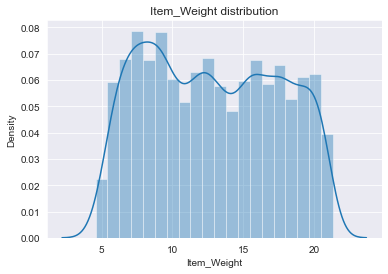

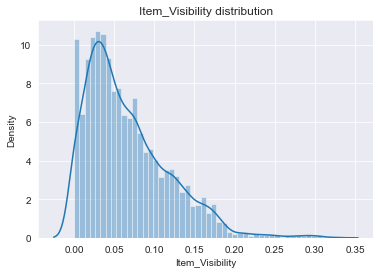

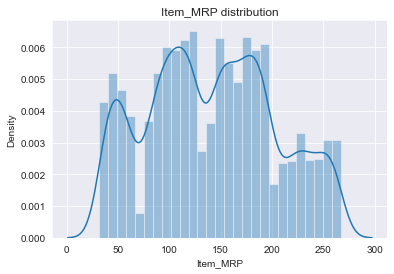

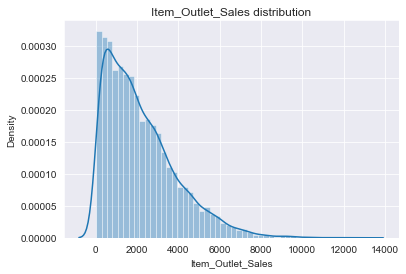

In [330]:
for feature in countinuous_num:
    sns.distplot(train_df[feature])
    plt.title('{} distribution'.format(feature))
    plt.show()

It could be observed from the above distribution plots that the _item_outles_Sales_ and _item_visibility_ are right skewed due to existence of outliers.

The _item_weight_ follows a uniform distribution as must of the weights seem to have equal likelihood of occuring.

### Identification of outliers
- To ensure that the model is not bias in predicting the sales, outliers must be identified and treated.This is to enable the model to be able to predict very high sales rather it predicting on moderate sales.
- Here the Box and QQ plots will be used to identified outliers

### Box plot

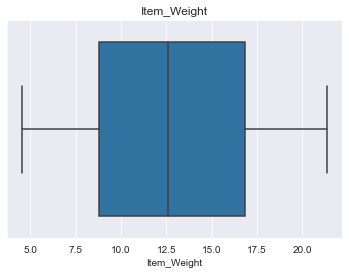

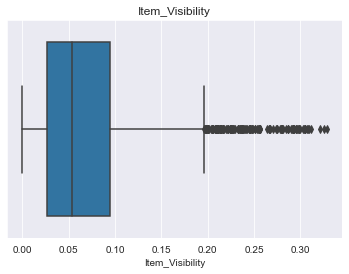

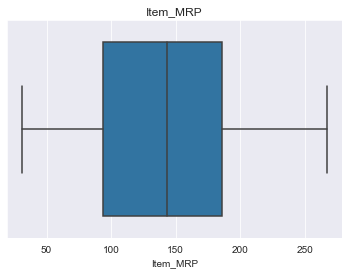

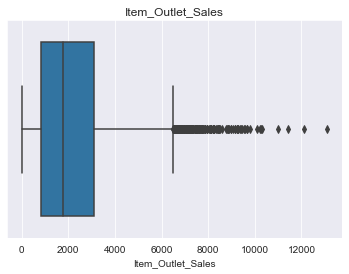

In [331]:
for feature in countinuous_num:
    sns.boxplot(train_df[feature])
    plt.title('{}'.format(feature))
    plt.show()

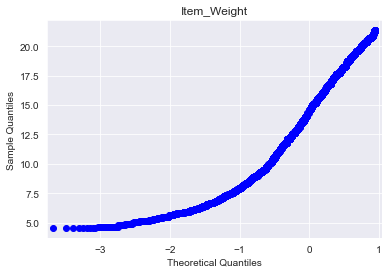

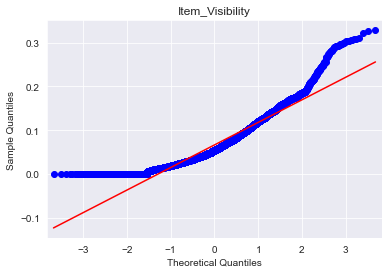

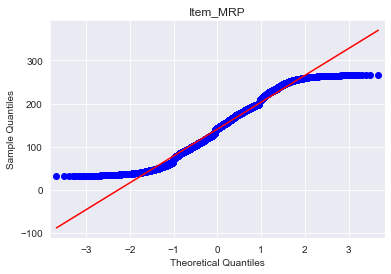

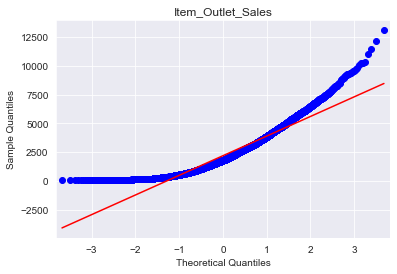

In [332]:
for feature in countinuous_num:
    sm.qqplot(train_df[feature],line = 's')
    plt.title('{}'.format(feature))
    plt.show()

The columns _items_outlet_sales, item_Visibility and item_MRP_ do not follow the normal distribution due to the existence of outliers.

These outliers could be observed on the QQ-plots above whereby the data points of the various columns do not follow a straight line.

### 5. Understanding the variation of sales with Idependent features

### Variation of sales with continuous numeric columns

In [333]:
cont_features = [feature for feature in countinuous_num if feature not in ['Item_Outlet_Sales']]

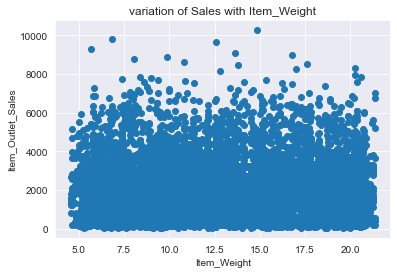

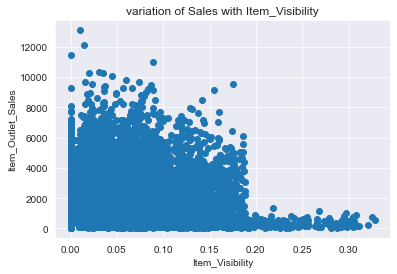

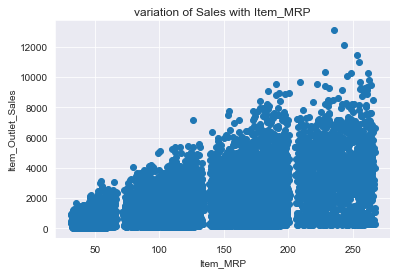

In [334]:
for feature in cont_features:
    plt.scatter(train_df[feature],train_df['Item_Outlet_Sales'])
    plt.title('variation of Sales with {}'.format(feature))
    plt.xlabel(feature)
    plt.ylabel('Item_Outlet_Sales')
    plt.show()
    

From the visualizations above the target column,_item_Outlet_Sales_ seem to have a strong positive correlation with the feature _item_MRP_.

### Time series Analysis
The main aim of this analysis is to have an understanding of the variation of sales over the years.

In [335]:
#grouping the data by year
yr_sales = train_df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum()

Text(0.5, 1.0, 'Variation of Item_Sales with Establishment_year')

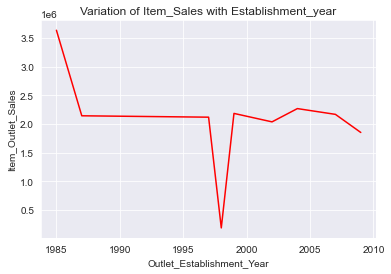

In [336]:
plt.plot(yr_sales.index,yr_sales.values,'r')
plt.xlabel('Outlet_Establishment_Year')
plt.ylabel('Item_Outlet_Sales')
plt.title('Variation of Item_Sales with Establishment_year')

From the above time series analysis it is observed that
- There was a decrease in sales to about 2.1 millions dollars from the year 1985 about 1987.
- From 1987 to 1997 the sales remain at 2.1m.
- The sales dropped dratically from 1997 to 1998 to about 0.2 millions.

### Variation of sales with categorical features

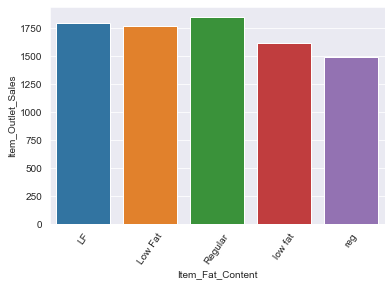

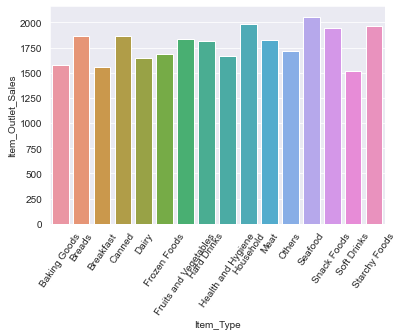

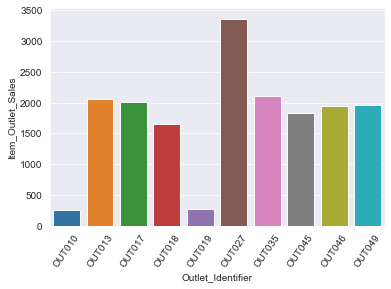

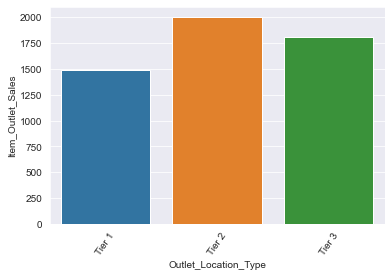

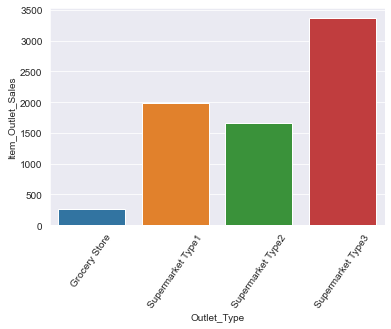

In [337]:
for feature in cat_feat:
    groupbyfeature  = train_df.groupby(feature)['Item_Outlet_Sales'].median()
    sns.barplot(groupbyfeature.index,groupbyfeature.values)
    plt.ylabel('Item_Outlet_Sales')
    plt.xlabel(feature)
    plt.xticks(rotation = 55)
    plt.show()

- From the above visualizations the sales seem to be uniformly distributed accross the _outlet_location_type_,_item_fat_content_ and _item_type_. 
- For the _outlet_Type_,sales turn to be higher for supermarket type3 and lowest for Grocery Store.

# Correlation Test

<AxesSubplot:>

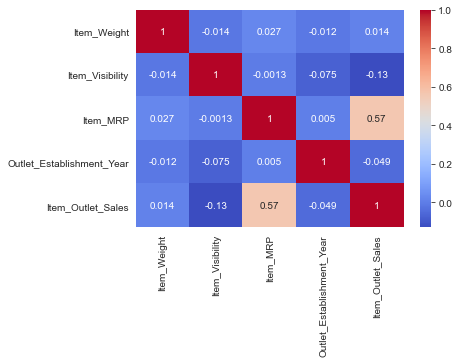

In [338]:
sns.heatmap(train_df.corr(method = 'pearson'),cmap = 'coolwarm',annot = True)

From correlation heatmap,the input features seem to be independent due to the weak correlations that exist within them.

The item_MRP columns seem to have a strong positive correlation with the sales.

### Statistical Summary of data

In [339]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


- From the descriptive analysis above, 75% of the sales were below 3101 dollars.
- The data found in the columns, _Item_Weight_ _Item_Visibility_	_Item_MRP	_Item_Outlet_Sales_ is right skewed.

# 4. Feature Engineering

Here the following identified during EDA will be taken care of;
- Imputation of NaN values in Categorical and Numerical features
- Handling Skewness and outliers(Normalizing the data or Scaling)
- OneHot encoding of categorical data
The output of this stage will be processed data ready for Machine learning model.

## Imputation of NaN values for Categorical Columns

This would be done using the most frequent category for each column.

In [340]:
from sklearn.impute import SimpleImputer

In [341]:
imputer = SimpleImputer(strategy = 'most_frequent')
# Fitting the imputers into the data
imputer.fit(train_df[cat_features])
# Imputing the NaN using the transform function
train_df[cat_features] = imputer.transform(train_df[cat_features])


In [342]:
## Checking for NaN in categorical columns
train_df[cat_features].isna().sum()

Item_Identifier         0
Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

## Imputation of NaN values in the numerical columns

This will be done using the median since it is not usually affected by outliers.

In [343]:
num_imputer = SimpleImputer(strategy = 'median')
num_imputer.fit(train_df[num_features])
train_df[num_features] = num_imputer.transform(train_df[num_features])

In [344]:
#Checking for NaN values in the numerical columns
train_df[num_features].isnull().sum()

Item_Weight                  0
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
Item_Outlet_Sales            0
dtype: int64

## Encoding of categorical columns

In [345]:
from sklearn.preprocessing import OneHotEncoder

In [346]:
encoder = OneHotEncoder(sparse = False)
encoder.fit(train_df[cat_features])
encoded_cols = list(encoder.get_feature_names(cat_features))
train_df[encoded_cols] = encoder.transform(train_df[cat_features])

## Scaling the independent numerical variables

In [347]:
#Input numerical features
numerical_features = [feature for feature in num_features if feature not in ['Item_Outlet_Sales']]

In [348]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df[numerical_features])
train_df[numerical_features] = scaler.transform(train_df[numerical_features])

## Splitting the dataset

In [349]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_df[numerical_features+encoded_cols],
                                             train_df['Item_Outlet_Sales'],test_size = 0.2,random_state = 42)

# NOTE:
- Data splitting into train and validation set has to be perormed before scaling, OneHotEncoding and imputation. 
- This is so as to avoid information about validation data from leaking into the training data.
- If this happens the model would be validated on data that it has already seen.
- Thus leading higher accuracy on validation set which does not really mean the model will perform better on unseen data.

In [350]:
x_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
549,0.294433,0.107207,0.594464,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7757,0.800536,0.144563,0.591057,0.708333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
764,0.776719,0.231802,0.341387,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6867,0.224472,0.090883,0.043819,0.708333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2716,0.493897,0.417880,0.527478,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [351]:
y_train.head()

549     2386.2272
7757    3103.9596
764     1125.2020
6867     284.2966
2716    4224.5010
Name: Item_Outlet_Sales, dtype: float64

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

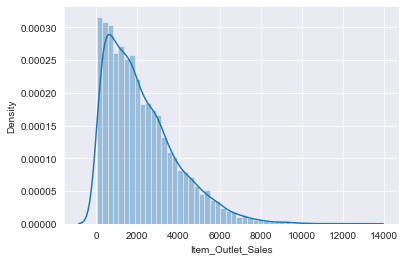

In [352]:
sns.distplot(y_train)

## Observation:
- Even after performing scaling on the data, the skewed columns(Item_Outlet_Sales,Item_MRP) still remain un normalized(Not normally distributed).

## Handling of outliers or Skewness using a scaler

Other method will include; 
- Log transformation
- The Square root transformation
- Box-cox Transformation

### Transforming the target (Item_outlet_Sales) using Square-Root Transformation

In [353]:
from scipy.special import inv_boxcox
from scipy import stats
y_train = np.sqrt(y_train)

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

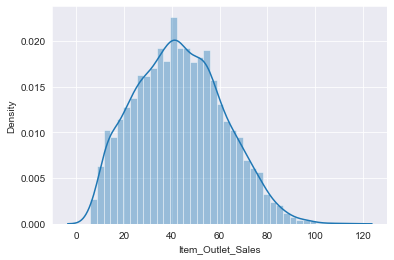

In [354]:
sns.distplot(y_train)

After performing square-root transformation it could be observed that the sales column has become less skewed.This enables the model not only to predict moderate sales but also to be able to predict very high  or very low sales.

# 4. Model Building
- Training a couple of models and selecting the best using RMSE
- Using the residual plots and r2 to check the goodness of fit of the model on the training set.

### Importing the Linear models and the Evaluation metrics

In [355]:
#Importing Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso,BayesianRidge
from sklearn.metrics import r2_score,mean_squared_error

## Creating a list of models to be trained

In [356]:
#Creating a list of of models to be trained
models = []
models.append(('LR',LinearRegression()))
models.append(('RR',Ridge()))
models.append(('LaR',Lasso()))
models.append(('BR',BayesianRidge()))

## NOTE
- Tree algorithms such as Decision Tree, Random Forest,XGBOOST,LGBM and CATBOOST regressors could also be used.

## Creating a function to automatically train and evaluates the models
- Train a couple models
- Make predictions
- Perform inverse square root transformation
- Evaluate models on validation and Trainset

In [357]:
r2score = []
model_name = []
Train_rmse = []
val_rmse = []
def train_validate_model(x_train,y_train,x_val,y_val,models):
    for name,model in models:
        #Fits the model into the data for training
        model.fit(x_train,y_train)
        #Make predictios on training and validation sets
        train_preds = (model.predict(x_train))**2
        val_preds = (model.predict(x_val))**2
        #Checking the goodness-of-fit of the model on the training set
        R2_score = r2_score(y_train**2,train_preds)
        r2score.append(R2_score)
        #Evaluating the model performance
        rmse_train = mean_squared_error(y_train**2,train_preds,squared = False)
        Train_rmse.append(rmse_train)
        rmse_val = mean_squared_error(y_val,val_preds,squared = False)
        val_rmse.append(rmse_val)
        model_name.append(name)
    #Creating a dataframe to hold the models data
    model_df = pd.DataFrame({'Modelname':model_name,'r2score':r2score,
                              'rmse_train':Train_rmse,'rmse_Val':val_rmse})
    return model_df

In [358]:
#Calling the train_validation function
train_validate_model(x_train,y_train,x_val,y_val,models)

,Modelname,r2score,rmse_train,rmse_Val
0,LR,0.691582,955.151970,3.499742e+24
1,RR,0.685649,964.295734,1.117994e+03
2,LaR,0.442289,1284.420416,1.199800e+03
3,BR,0.639859,1032.141203,1.048706e+03


## Selecting the best linear model using RMSE

- Making use of the RMSE and R2-value the right candidate among Lasso,Linear,Ridge and Bayesian regression is the _Bayesian regression_.
- It has an RMSE value of 1032 on training set and 1049 on validation set.
- Also, using r2score it has about 64% variation of sales is explained by ridge regression.
- The Lasso regression fits the data poorly.
- Linear Regression overfits the data. Thus performing poorly on the validation dataset.

### Using the residuals plots to check the goodness of fit of Lasso

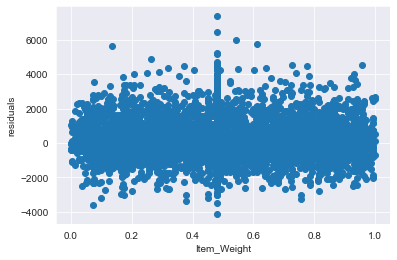

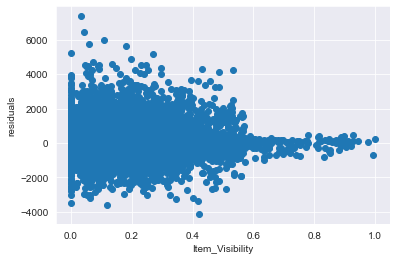

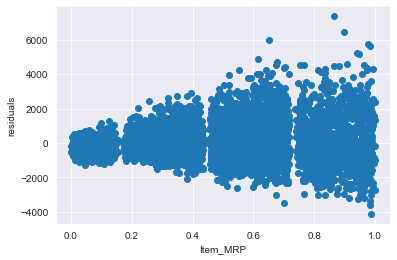

In [359]:
model = BayesianRidge()
model.fit(x_train,y_train)
train_pred = (model.predict(x_train))**2
residuals = y_train**2 - train_pred
for feature in cont_features:
    plt.scatter(x_train[feature],residuals)
    plt.xlabel(feature)
    plt.ylabel('residuals')
    plt.show()

- From the residual plots above the errors generated by Bayesian regression seem to be symmetrically distributed about the x-axis. 
- This means that Bayesian regression some how fits the data well too.

## Feature Selection

-  L1 regularization (Lasso Regression)
-  Principal Component Analysis(PCA)

## L1 regularization (Lasso Regression)

In [360]:
FeatSelect = Lasso()
FeatSelect.fit(x_train,y_train)

Lasso()

In [361]:
Feature_importances = pd.Series(FeatSelect.coef_,index = x_train.columns)

In [362]:
Feature_importances

Item_Weight                      -0.000000
Item_Visibility                  -0.000000
Item_MRP                         24.768239
Outlet_Establishment_Year        -0.000000
Item_Identifier_DRA12            -0.000000
                                   ...    
Outlet_Location_Type_Tier 3       0.000000
Outlet_Type_Grocery Store       -19.846920
Outlet_Type_Supermarket Type1     0.000000
Outlet_Type_Supermarket Type2    -0.000000
Outlet_Type_Supermarket Type3     0.000000
Length: 1604, dtype: float64

<AxesSubplot:>

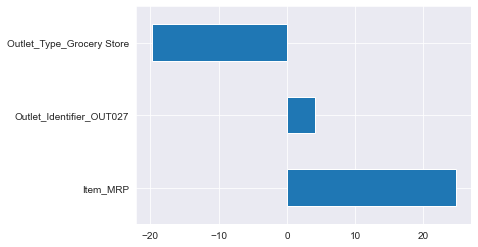

In [363]:
Feature_importances[Feature_importances !=0].plot(kind = 'barh')

- The L1 regularization technique, Lasso helps to shrink the coefficients of the features that of lower importance during sales prediction to zero.
- From above visualization, the feature _outlet_Type_Grocery_store_,_Outlet_Identifier_OUT027_ and _Item_MRP_ are the 3 key features that can be used in Sales prediction.
- But training the model on just 3 features,would be underfitting the model

# Machine Learning Pipeline Design

### Import Libraries

In [364]:
#Import important libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge,Lasso,BayesianRidge,LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

### Load dataset

In [377]:
#Loading data
data = pd.read_csv('D:/sqldatasets/train.csv')

### Split dataset into train and Validation sets

In [378]:
#Splitting the data in the ratio 80:20
train_data,val_data = train_test_split(data,test_size = 0.2,random_state = 42)
x_train = train_data.drop(columns = ['Item_Outlet_Sales']) 
y_train = train_data['Item_Outlet_Sales'] 
x_val = val_data.drop(columns = ['Item_Outlet_Sales']) 
y_val = val_data['Item_Outlet_Sales'] 

### Numerical features processing pipeline

In [379]:
#Building a Pipeline for Preprocessing numberical features
numerical_pipeline = Pipeline([ ('numerical_imputer',SimpleImputer(strategy = 'median')),
                     ('Feature_scaling',MinMaxScaler())])

### Categorical features processing pipeline

In [380]:
#Building Pipeline for preprocessing of categorical features
categorical_pipeline = Pipeline([('categorical_imputer',SimpleImputer(strategy = 'most_frequent')),
                                 ('categorical_encoder',OneHotEncoder(sparse = False))])


### Custom function to add important features to the dataset

In [381]:
#Creating a custom function to extract only important features to be used for prediction
class ExtractImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,document,y=None):
        return self
    def transform(self,x_dataset):
        x_dataset['Outlet_Type_Grocery Store'] = (x_dataset['Outlet_Type']=='Grocery Store')*1
        x_dataset['Outlet_Identifier_OUT027'] = (x_dataset['Outlet_Identifier']=='OUT027')*1
        return x_dataset

### Creating a custom function to drop less important features

In [382]:
#Creating a custom function to drop less important features
class DropFeatures(BaseEstimator, TransformerMixin):
    """
    Drop features
    """
    def __init__(self, drop_columns):
        self.drop_columns = drop_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Drop features
        """
        X = X.drop(columns=self.drop_columns, axis=1)
        return X

### Creating column transformer 

In [383]:
#Building a column transformer to simultaneously transform numerical and categorical columns
# Using numerical and categorical features pipelines
numerical_columns = x_train.select_dtypes(exclude = 'object').columns.tolist()
categorical_columns = x_train.select_dtypes(include = 'object').columns.tolist()

#Column Transformer
column_Pipeline = ColumnTransformer([('numerical_pipeline',numerical_pipeline,numerical_columns),
                                     ('categorical_pipeline',categorical_pipeline,categorical_columns)])


### Full data pipeline for data processing with PCA
- Creating a full data processing pipeline with PCA,
- Processing the data using the pipeline,
- Making predictions on train and test sets

In [384]:
# A full pipeline to process the input data and perform
full_pipeline = Pipeline([('column_pipeline',column_Pipeline),
                         ('pca',PCA(n_components = 2))])
#Transform the input
processed_data = full_pipeline.fit_transform(x_train)
Model = BayesianRidge()
#Fitting a model in the processed data
Model.fit(processed_data,y_train)
#Making predictions on Train set
train_pred = Model.predict(processed_data)
print('Predictions on Train_set:',train_pred)
#Predictions on Test set

Predictions on Train_set: [2171.95678287 2428.7688181  1871.60207081 ... 2430.88336328 2444.87430073
 1874.92184524]


In [385]:
test_data = full_pipeline.fit_transform(test_df)
test_preds = Model.predict(test_data)
print('Predictions on test_set:',test_preds)

Predictions on test_set: [2181.75103786 2447.83471774 2258.5585834  ... 2431.4520953  2444.49736769
 2422.96676671]


## Observation
- While trying to make predictions on the validation and test sets without PCA applied,a mismatch error was observed as the number columns of the processed data on which the model was trained was different from the number of columns of the processed test and validation sets. 
- This could be because there were some categories in the train set that were not found on the test and validation sets.
- To avoid this error PCA was used to process both the training and validation or test data and bring them to common number of columns after processing.

### Creating a full pipeline for data processing with Drop_features Custom function

In [386]:
#Creating an ML pipeline that select on the important features
drop_columns = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Outlet_Identifier','Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type']

column_Pipeline2 = ColumnTransformer([('numerical_pipeline',numerical_pipeline,['Item_MRP'])])


full_pipeline2 = Pipeline([('ExtractImportantFeatures',ExtractImportantFeatures()),
                          ('drop_features', DropFeatures(drop_columns)),
                          ('column_pipeline2',column_Pipeline2)])
processed_data2 = full_pipeline2.fit_transform(x_train)
Model2 = Ridge()
Model2.fit(processed_data2,y_train).predict(processed_data2)


array([2659.06795837, 2646.61708323, 1734.10103857, ..., 3683.15786818,
       1830.69227825, 1486.21289501])

ML pipelines could further be used for:
- Preprocessing features only
- Including models into the pipeline
- Hyper-parameter tuning